# Predicting CO2 emissions of passenger cars sold in the EU

In this notebook, we investigate a public dataset related to the
[Monitoring of CO2 emissions from passenger cars Regulation (EU) 2019/631](https://www.eea.europa.eu/en/datahub/datahubitem-view/fa8b1229-3db6-495d-b18e-9c9b3267c02b).

According to the European Environment Agency (EEA):
> The Regulation (EU) No 2019/631 requires Countries to record information for each new passenger car registered in its territory. Every year, each Member State shall submit to the Commission all the information related to their new registrations. In particular, the following details are required for each new passenger car registered: manufacturer name, type approval number, type, variant, version, make and commercial name, specific emissions of CO2 (NEDC and WLTP protocols), masses of the vehicle, wheel base, track width, engine capacity and power, fuel type and mode, eco-innovations and electricity consumption. Data for EU-27 and UK are reported in the main database.

Our goal is to understand what this dataset contains in order to design a machine
learning model capable of predicting CO2 emissions based on vehicle specs.

## Loading the dataset

The dataset we are working with has been downloaded from the [EEA website](https://co2cars.apps.eea.europa.eu/?source=%7B%22track_total_hits%22%3Atrue%2C%22query%22%3A%7B%22bool%22%3A%7B%22must%22%3A%5B%7B%22constant_score%22%3A%7B%22filter%22%3A%7B%22bool%22%3A%7B%22must%22%3A%5B%7B%22bool%22%3A%7B%22should%22%3A%5B%7B%22term%22%3A%7B%22year%22%3A%222015%22%7D%7D%5D%7D%7D%2C%7B%22bool%22%3A%7B%22should%22%3A%5B%7B%22term%22%3A%7B%22scStatus%22%3A%22Final%22%7D%7D%5D%7D%7D%5D%7D%7D%7D%7D%5D%7D%7D%2C%22display_type%22%3A%22tabular%22%2C%22from%22%3A10%7D)
where we selected status: Final and year: 2015 as filters.

### How to run a notebook cell

Notebooks allow users to run commands as if they were in a terminal by simply
starting their command with an exclamation mark `!`.

For example, we can display the header and the first five rows of our
CSV (comma-separated values) file with the following `head` command:
```bash
head -n 6 datasets/co2_emissions_new_passenger_cars_eu_2015.csv
```

To run the cell below:
1. select the cell with your mouse
2. press shift+enter or press the play button

In [1]:
!head -n 6 datasets/co2_emissions_new_passenger_cars_eu_2015.csv

ID,Country,VFN,Mp,Mh,Man,MMS,Tan,T,Va,Ve,Mk,Cn,Ct,Cr,r,m (kg),Mt,Enedc (g/km),Ewltp (g/km),W (mm),At1 (mm),At2 (mm),Ft,Fm,ec (cm3),ep (KW),z (Wh/km),IT,Ernedc (g/km),Erwltp (g/km),De,Vf,Status,year,Date of registration,Fuel consumption ,Electric range (km)
280060,GB,,VW GROUP PC,VOLKSWAGEN,VOLKSWAGEN AG,VOLKSWAGEN,e1*2001/116*0471*20,13,ADCUUB,FM6FM62Q0257MMVR2N1RL62,VOLKSWAGEN,SCIROCCO BLUEMOTION TECH TDI,M1,,5,1375,,109,,2575,1552,1558,diesel,M,1968,,,,,,,,F,2015,,,
280061,GB,,VW GROUP PC,VOLKSWAGEN,VOLKSWAGEN AG,VOLKSWAGEN,e1*2001/116*0471*20,13,ADCUWA,FM6FM6FB0017MMVR2N1RL62,VOLKSWAGEN,SCIROCCO GT BLUEMOTN TECH TDI,M1,,3,1395,,115,,2575,1552,1558,diesel,M,1968,,,,,,,,F,2015,,,
280062,GB,,VW GROUP PC,VOLKSWAGEN,VOLKSWAGEN AG,VOLKSWAGEN,e1*2001/116*0510*21,6R,ABCUSB,FM5FM5A4054N2VR27MM,VOLKSWAGEN,POLO SEL TDI,M1,,8,1151,,88,,2456,1441,1434,diesel,M,1422,,,,,,,,F,2015,,,
280063,GB,,VW GROUP PC,VOLKSWAGEN,VOLKSWAGEN AG,VOLKSWAGEN,e1*2001/116*0510*22,6R,ABCHYA,FM5FM5CF007N3VR27MM,VOLKSW

Notice that the output of the command is written directly below the cell.
This will also be the case for figures and tables.

Observations
- the first row contains column names, most of which are very abbreviated
- some column names come with physical units
- numerical values seem to be represented as integers
- non-numerical values are either strings or codes

In [2]:
import pandas as pd

In [3]:
eu_cars = (
    pd.read_csv(
        'datasets/co2_emissions_new_passenger_cars_eu_2015.csv',
        low_memory=False,
        sep=',',
    )
    .rename(
        axis='columns',
        mapper={
            'ID': 'vehicle_id',
            'Country': 'country',
            'VFN': 'vehicle_family',
            'Mp': 'pool',
            'Mh': 'manufacturer_name_eu',
            'Man': 'manufacturer_name_self_reported',
            'MMS': 'manufacturer_name_registry',
            'Tan': 'type_approval_number',
            'T': 'type',
            'Va': 'variant',
            'Ve': 'version',
            'Mk': 'make',
            'Cn': 'commercial_name',
            'Ct': 'approved_vehicle_type_category',
            'Cr': 'registered_vehicle_type_category',
            'r': 'total_new_registrations',
            'm (kg)': 'mass_running_order_in_kg',
            'Mt': 'wltp_test_mass',
            'Enedc (g/km)': 'nedc_co2_emissions_in_grams_per_km',
            'Ewltp (g/km)': 'wltp_co2_emissions_in_grams_per_km',
            'W (mm)': 'wheel_base_in_mm',
            'At1 (mm)': 'steering_axle_width_in_mm',
            'At2 (mm)': 'other_axle_width_in_mm',
            'Ft': 'raw_fuel_type',
            'Fm': 'fuel_mode',
            'ec (cm3)': 'engine_capacity_in_cm3',
            'ep (KW)': 'engine_power_in_kilowatts',
            'z (Wh/km)': 'electric_energy_consumption_in_watthours_per_km',
            'IT': 'innovative_technology',
            'Ernedc (g/km)': 'nedc_co2_emissions_reduction_in_grams_per_km',
            'Erwltp (g/km)': 'wltp_co2_emissions_reduction_in_grams_per_km',
            'De': 'deviation_factor',
            'Vf': 'verification_factor',
            'Status': 'status',
            'year': 'year',
            'Date of registration': 'registration_date',
            'Fuel consumption ': 'fuel_consumption',
            'Electric range (km)': 'electric_range_in_km',
        },
    )
    .assign(
        fuel_type=lambda x: x.raw_fuel_type
            .str.lower()
            .str.replace('petrol phev', 'petrol-electric')
            .str.replace('hybrid/petrol/e', 'petrol-electric')
            .str.replace('/', '-')
    )
    .astype(
        {
            c: 'category' for c in
            ['country', 'fuel_type', 'fuel_mode', 'status', 'pool', 'manufacturer_name_eu']
            # ['pool', 'manufacturer_name_eu',
            # 'manufacturer_name_self_reported', 'manufacturer_name_registry',
            # 'type_approval_number', 'type', 'variant', 'version', 'make',
            # 'commercial_name', 'approved_vehicle_type_category',
            # 'innovative_technology',]
        }
    )
    .dropna(axis='columns', how='all')
    .drop(axis='columns', labels='year')
    .set_index('vehicle_id')
)

In [4]:
eu_cars.head(5)

,country,pool,manufacturer_name_eu,manufacturer_name_self_reported,manufacturer_name_registry,type_approval_number,type,variant,version,make,...,other_axle_width_in_mm,raw_fuel_type,fuel_mode,engine_capacity_in_cm3,engine_power_in_kilowatts,electric_energy_consumption_in_watthours_per_km,innovative_technology,nedc_co2_emissions_reduction_in_grams_per_km,status,fuel_type
vehicle_id,,,,,,,,,,,,,,,,,,,,,
280060,GB,VW GROUP PC,VOLKSWAGEN,VOLKSWAGEN AG,VOLKSWAGEN,e1*2001/116*0471*20,13,ADCUUB,FM6FM62Q0257MMVR2N1RL62,VOLKSWAGEN,...,1558.0,diesel,M,1968.0,NaN,NaN,NaN,NaN,F,diesel
280061,GB,VW GROUP PC,VOLKSWAGEN,VOLKSWAGEN AG,VOLKSWAGEN,e1*2001/116*0471*20,13,ADCUWA,FM6FM6FB0017MMVR2N1RL62,VOLKSWAGEN,...,1558.0,diesel,M,1968.0,NaN,NaN,NaN,NaN,F,diesel
280062,GB,VW GROUP PC,VOLKSWAGEN,VOLKSWAGEN AG,VOLKSWAGEN,e1*2001/116*0510*21,6R,ABCUSB,FM5FM5A4054N2VR27MM,VOLKSWAGEN,...,1434.0,diesel,M,1422.0,NaN,NaN,NaN,NaN,F,diesel
280063,GB,VW GROUP PC,VOLKSWAGEN,VOLKSWAGEN AG,VOLKSWAGEN,e1*2001/116*0510*22,6R,ABCHYA,FM5FM5CF007N3VR27MM,VOLKSWAGEN,...,1434.0,petrol,M,999.0,NaN,NaN,NaN,NaN,F,petrol
280064,GB,VW GROUP PC,VOLKSWAGEN,VOLKSWAGEN AG,VOLKSWAGEN,e1*2001/116*0510*22,6R,ABCJZC,FM5FM52T106N2VR27MM,VOLKSWAGEN,...,1434.0,petrol,M,1197.0,NaN,NaN,NaN,NaN,F,petrol


In [5]:
eu_cars.info()

<class 'pandas.core.frame.DataFrame'>
Index: 440645 entries, 280060 to 343109
Data columns (total 27 columns):
 #   Column                                           Non-Null Count   Dtype   
---  ------                                           --------------   -----   
 0   country                                          440645 non-null  category
 1   pool                                             382812 non-null  category
 2   manufacturer_name_eu                             440645 non-null  category
 3   manufacturer_name_self_reported                  440645 non-null  object  
 4   manufacturer_name_registry                       416338 non-null  object  
 5   type_approval_number                             428046 non-null  object  
 6   type                                             437911 non-null  object  
 7   variant                                          434992 non-null  object  
 8   version                                          426616 non-null  object  
 9   make

## Exploratory data analysis

In [6]:
import seaborn as sns

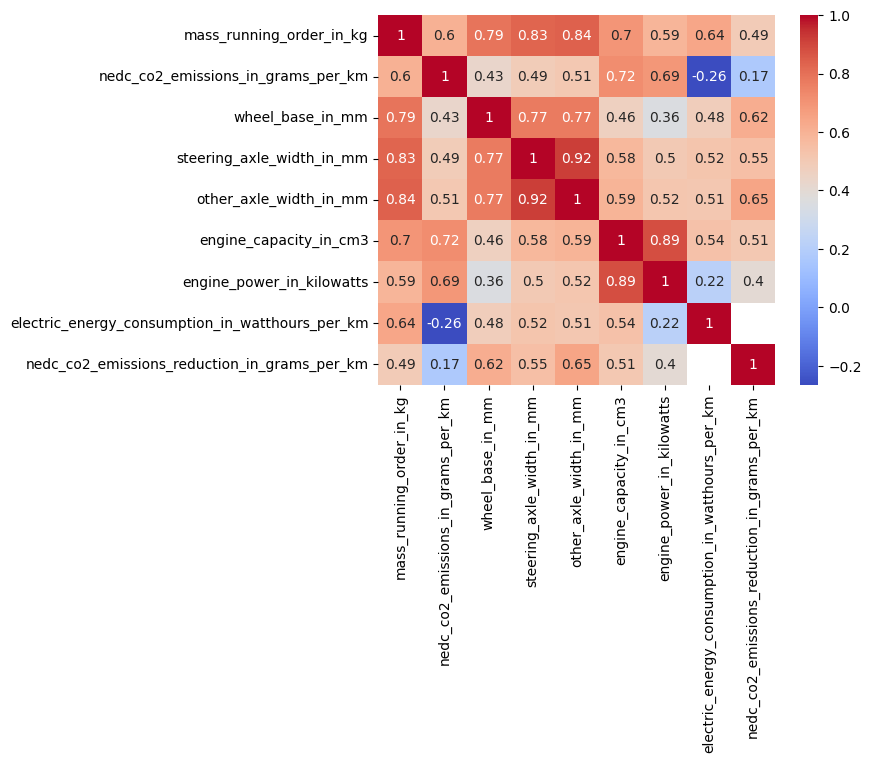

In [7]:
sns.heatmap(
    data=(
        eu_cars
        .select_dtypes(include=['int64', 'float64'])
        .drop(axis='columns', labels='total_new_registrations')
        .corr()
    ),
    cmap='coolwarm',
    annot=True,
);

/Users/beaujeanpaul/Projects/talks/.env/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/beaujeanpaul/Projects/talks/.env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


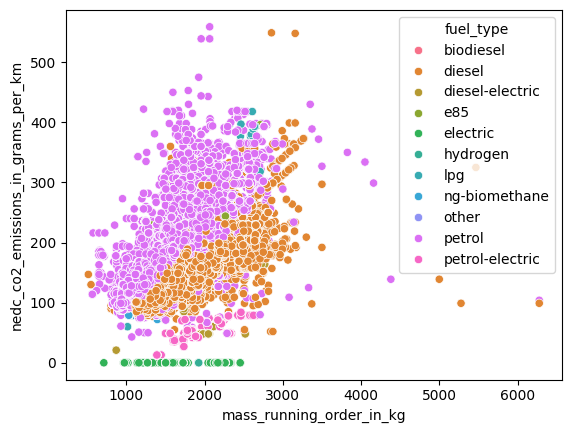

In [8]:
sns.scatterplot(
    data=eu_cars,
    x='mass_running_order_in_kg',
    y='nedc_co2_emissions_in_grams_per_km',
    hue='fuel_type',
);

In [9]:
[column_name for column_name in eu_cars.columns if 'co2' in column_name]

['nedc_co2_emissions_in_grams_per_km',
 'nedc_co2_emissions_reduction_in_grams_per_km']

In [10]:
eu_cars.nedc_co2_emissions_in_grams_per_km.isnull().sum()

797

<Axes: ylabel='Frequency'>

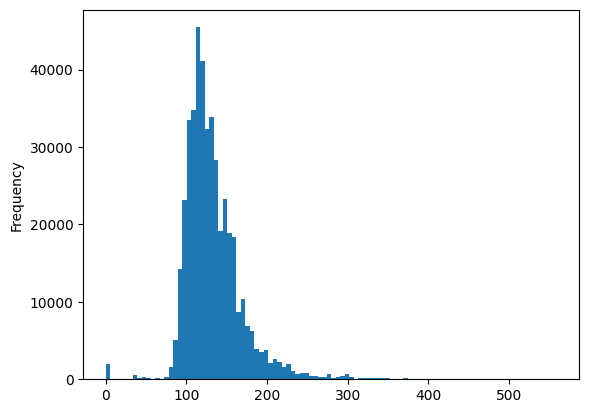

In [11]:
eu_cars.nedc_co2_emissions_in_grams_per_km.plot.hist(bins=100)

In [12]:
from sklearn.model_selection import train_test_split

X = (
    eu_cars
    [~eu_cars.nedc_co2_emissions_in_grams_per_km.isnull()]
    [[
        # numerics
        'total_new_registrations',
        'mass_running_order_in_kg',
        'wheel_base_in_mm',
        'steering_axle_width_in_mm',
        'other_axle_width_in_mm',
        'engine_capacity_in_cm3',
        'engine_power_in_kilowatts',
        'electric_energy_consumption_in_watthours_per_km',
        # categories
        'country',
        'pool',
        'fuel_mode',
        'fuel_type'
    ]]
)

y = (
    eu_cars
    [~eu_cars.nedc_co2_emissions_in_grams_per_km.isnull()]
    .nedc_co2_emissions_in_grams_per_km
)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 351878 entries, 69906 to 322028
Data columns (total 12 columns):
 #   Column                                           Non-Null Count   Dtype   
---  ------                                           --------------   -----   
 0   total_new_registrations                          351878 non-null  int64   
 1   mass_running_order_in_kg                         351803 non-null  float64 
 2   wheel_base_in_mm                                 343401 non-null  float64 
 3   steering_axle_width_in_mm                        344480 non-null  float64 
 4   other_axle_width_in_mm                           331901 non-null  float64 
 5   engine_capacity_in_cm3                           350246 non-null  float64 
 6   engine_power_in_kilowatts                        291527 non-null  float64 
 7   electric_energy_consumption_in_watthours_per_km  2411 non-null    float64 
 8   country                                          351878 non-null  category
 9   pool 

In [14]:
y_train.info()

<class 'pandas.core.series.Series'>
Index: 351878 entries, 69906 to 322028
Series name: nedc_co2_emissions_in_grams_per_km
Non-Null Count   Dtype  
--------------   -----  
351878 non-null  float64
dtypes: float64(1)
memory usage: 5.4 MB


In [15]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
import numpy as np

ordinal_encoder = make_column_transformer(
    (
        OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan),
        make_column_selector(dtype_include="category"),
    ),
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform='pandas')

In [16]:
from sklearn.ensemble import HistGradientBoostingRegressor

hist_native = make_pipeline(
    ordinal_encoder,
    HistGradientBoostingRegressor(random_state=42),
)

In [17]:
hist_native.fit(X_train, y_train)

transformed_X_test = hist_native.steps[0][1].fit_transform(X_test)
y_pred = hist_native.steps[1][1].predict(transformed_X_test)

In [18]:
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    median_absolute_error,
    max_error,
)

mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
mae = mean_absolute_error(y_true=y_test, y_pred=y_pred)
r2 = r2_score(y_true=y_test, y_pred=y_pred)
medae = median_absolute_error(y_true=y_test, y_pred=y_pred)
maxe = max_error(y_true=y_test, y_pred=y_pred)

print(
    f"""
    Mean Squared Error (MSE): {mse:.2f} [penalizes large deviations]
    Root Mean Squared Error (RMSE): {np.sqrt(mse):.2f} [MSE scaled to original quantity]
    Mean Absolute Error (MAE): {mae:.2f} [penalizes deviations proportionally]
    Median Absolute Error (MedAE): {medae:.2f} [similar to MAE but robust to outliers]
    Maximum Error: {maxe:.2f} [largest deviation measured]
    ---
    R2 Score (100% is best possible): {r2:.3%} [proportion of variance explained]

    """
)


    Mean Squared Error (MSE): 206.68 [penalizes large deviations]
    Root Mean Squared Error (RMSE): 14.38 [MSE scaled to original quantity]
    Mean Absolute Error (MAE): 10.11 [penalizes deviations proportionally]
    Median Absolute Error (MedAE): 7.27 [similar to MAE but robust to outliers]
    Maximum Error: 225.12 [largest deviation measured]
    ---
    R2 Score (100% is best possible): 84.139% [proportion of variance explained]

    


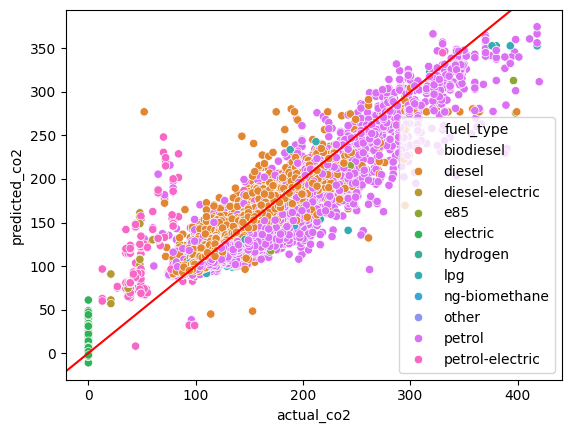

In [19]:
results = pd.DataFrame(dict(
    actual_co2=y_test,
    predicted_co2=y_pred,
    prediction_error=y_test - y_pred,
    absolute_error=np.abs(y_test - y_pred),
    squared_error=(y_test - y_pred)**2,
    mass_running_order_in_kg=X_test.mass_running_order_in_kg,
    engine_power_in_kilowatts=X_test.engine_power_in_kilowatts,
    fuel_type=X_test.fuel_type,
))

g = sns.scatterplot(
    data=results,
    x='actual_co2',
    y='predicted_co2',
    hue='fuel_type',
)

g.axline((0,0), (100,100), color='red')

In [20]:
results.sort_values(by='prediction_error')

,actual_co2,predicted_co2,prediction_error,absolute_error,squared_error,mass_running_order_in_kg,engine_power_in_kilowatts,fuel_type
vehicle_id,,,,,,,,
132080,52.0,277.119549,-225.119549,225.119549,50678.811567,2843.0,96.0,diesel
14,70.0,248.194594,-178.194594,178.194594,31753.313474,1762.0,447.0,petrol-electric
231124,70.0,230.625557,-160.625557,160.625557,25800.569665,1709.0,447.0,petrol-electric
145895,72.0,224.542023,-152.542023,152.542023,23269.068765,1750.0,447.0,petrol-electric
231123,72.0,223.842396,-151.842396,151.842396,23056.113259,1750.0,447.0,petrol-electric
...,...,...,...,...,...,...,...,...
390989,261.0,132.303004,128.696996,128.696996,16562.916842,1854.0,140.0,diesel
146500,343.0,203.766399,139.233601,139.233601,19385.995754,1148.0,317.0,petrol
138504,390.0,235.069347,154.930653,154.930653,24003.507220,1626.0,430.0,petrol


In [21]:
with_predictions = (
    X_test
    .assign(
        actual_co2=y_test,
        predicted_co2=y_pred,
        prediction_error=y_test - y_pred,
        absolute_error=np.abs(y_test - y_pred),
        squared_error=(y_test - y_pred)**2,
        number_of_nulls=lambda x: x.isnull().sum(axis='columns'),
        number_of_numerical_nulls=lambda x: x.select_dtypes(include=['float64', 'int64']).isnull().sum(axis='columns'),
    )
)

with_predictions.sort_values(by='prediction_error')

,total_new_registrations,mass_running_order_in_kg,wheel_base_in_mm,steering_axle_width_in_mm,other_axle_width_in_mm,engine_capacity_in_cm3,engine_power_in_kilowatts,electric_energy_consumption_in_watthours_per_km,country,pool,fuel_mode,fuel_type,actual_co2,predicted_co2,prediction_error,absolute_error,squared_error,number_of_nulls,number_of_numerical_nulls
vehicle_id,,,,,,,,,,,,,,,,,,,
132080,1,2843.0,NaN,NaN,NaN,2287.0,96.0,NaN,DE,NaN,M,diesel,52.0,277.119549,-225.119549,225.119549,50678.811567,5,4
14,2,1762.0,2730.0,1648.0,1612.0,4593.0,447.0,127.0,AT,NaN,M,petrol-electric,70.0,248.194594,-178.194594,178.194594,31753.313474,1,0
231124,2,1709.0,2730.0,1648.0,1612.0,4593.0,447.0,127.0,FR,VW GROUP PC,M,petrol-electric,70.0,230.625557,-160.625557,160.625557,25800.569665,0,0
145895,42,1750.0,2730.0,1648.0,1612.0,4593.0,447.0,127.0,DE,VW GROUP PC,M,petrol-electric,72.0,224.542023,-152.542023,152.542023,23269.068765,0,0
231123,6,1750.0,2730.0,1648.0,1612.0,4593.0,447.0,211.0,FR,VW GROUP PC,M,petrol-electric,72.0,223.842396,-151.842396,151.842396,23056.113259,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390989,1,1854.0,2774.0,1586.0,1632.0,1969.0,140.0,NaN,PL,NaN,M,diesel,261.0,132.303004,128.696996,128.696996,16562.916842,2,1
146500,1,1148.0,NaN,NaN,NaN,3496.0,317.0,NaN,DE,NaN,M,petrol,343.0,203.766399,139.233601,139.233601,19385.995754,5,4
138504,1,1626.0,NaN,NaN,NaN,3982.0,430.0,NaN,DE,DAIMLER AG,M,petrol,390.0,235.069347,154.930653,154.930653,24003.507220,4,4


<Axes: ylabel='Frequency'>

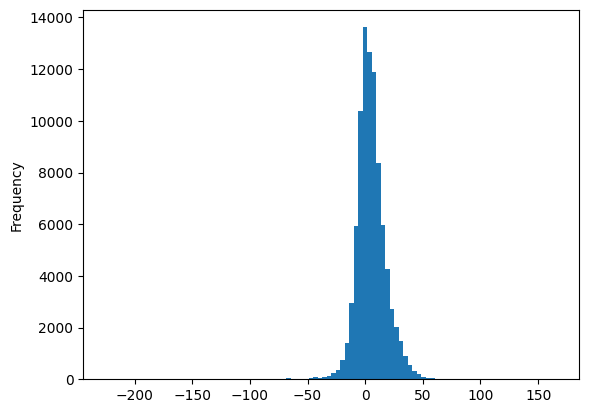

In [22]:
with_predictions.prediction_error.plot.hist(bins=100)

<Axes: xlabel='prediction_error', ylabel='Count'>

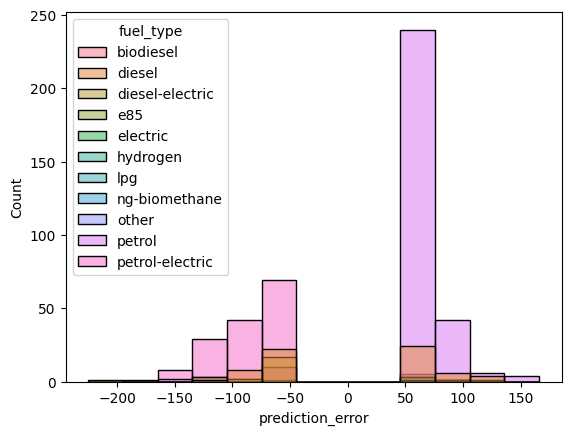

In [23]:
sns.histplot(
    data=with_predictions[with_predictions.absolute_error > 50],
    hue='fuel_type',
    x='prediction_error',
)

<Axes: xlabel='number_of_numerical_nulls', ylabel='prediction_error'>

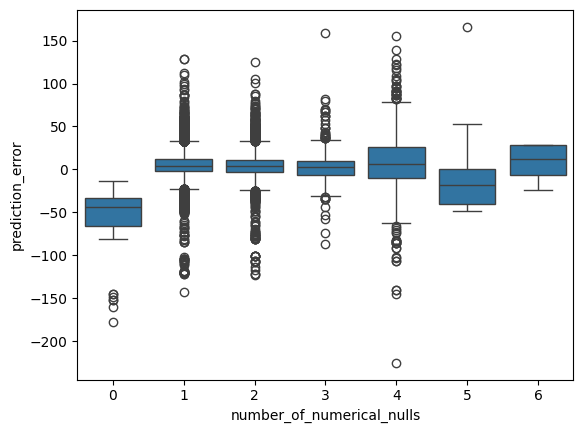

In [24]:
sns.boxplot(
    data=with_predictions,
    x='number_of_numerical_nulls',
    y='prediction_error',
)